### Importing Libraries

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

### Defining Constants

In [2]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

DIRECTORY = r".\dataset"
CATEGORIES = ["with_mask", "without_mask"]

### Load Images

In [3]:
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        data.append(image)
        labels.append(category)

### One-Hot Encoding

In [4]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

trainX, testX, trainY, testY = train_test_split(data,labels,test_size=0.20, stratify=labels, random_state=42)

In [5]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [6]:
baseModel = MobileNetV2(weights="imagenet",include_top=False,input_tensor=Input(shape=(224, 224, 3)))

In [7]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [8]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [9]:
for layer in baseModel.layers:
    layer.trainable = False

### Compiling Model

In [10]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

### Training

In [11]:
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS
)

Epoch 1/20
95/95 [==============================] - 84s 859ms/step - loss: 0.4245 - accuracy: 0.8481 - val_loss: 0.1883 - val_accuracy: 0.9831
Epoch 2/20
95/95 [==============================] - 79s 831ms/step - loss: 0.1690 - accuracy: 0.9595 - val_loss: 0.0940 - val_accuracy: 0.9870
Epoch 3/20
95/95 [==============================] - 86s 902ms/step - loss: 0.1087 - accuracy: 0.9733 - val_loss: 0.0675 - val_accuracy: 0.9883
Epoch 4/20
95/95 [==============================] - 91s 958ms/step - loss: 0.0833 - accuracy: 0.9789 - val_loss: 0.0490 - val_accuracy: 0.9922
Epoch 5/20
95/95 [==============================] - 89s 940ms/step - loss: 0.0693 - accuracy: 0.9792 - val_loss: 0.0432 - val_accuracy: 0.9922
Epoch 6/20
95/95 [==============================] - 93s 977ms/step - loss: 0.0569 - accuracy: 0.9822 - val_loss: 0.0405 - val_accuracy: 0.9922
Epoch 7/20
95/95 [==============================] - 93s 976ms/step - loss: 0.0501 - accuracy: 0.9858 - val_loss: 0.0360 - val_accuracy: 0.9922

### Evaluating Network

In [12]:
predIdxs = model.predict(testX,batch_size=BS)

In [13]:
predIdxs = np.argmax(predIdxs, axis=1)

In [14]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



### Saving Model

In [15]:
model.save("mask_detector.model",save_format="h5")

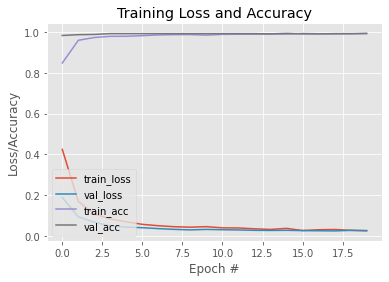

In [16]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")